In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from brian2 import *

### Architecture du GNW

4 régions : Input 1 et 2, Kernel et Output.

Il s'agit surtout ici de définir les paramètres généraux du GNW et de l'afficher de manière lisible.

On n'utilise pas d'objet Brian et on ne définit donc pas les modèles de synapse ou de neurones.

On se concentre sur **l'architecture**.

In [2]:
COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#473C8B', '#458B74',
          '#CD7F32', '#FF4040', '#ADFF2F', '#8E2323', '#FF1493']

alphanum = np.concatenate((np.arange(48, 58), np.arange(65, 65+26)))
def name(length=16):
    return ''.join([chr(alphanum[n]) for n in np.random.randint(low=0, 
                                                                high=len(alphanum), 
                                                                size=length)])

In [3]:
class Region():
    def __init__(self, nam=None, siz=[1,1], pos=[0,0], col=None):
        if nam==None:
            self.nam = name()
        else:
            self.nam = nam

        if col==None:
            self.col = COLORS[np.random.randint(len(COLORS))]
        else:
            self.col = col
            
        self.siz = siz
        self.pos = pos

In [4]:
areas = ["Input1",
         "Input2",
         "Kernel",
         "Output"]

In [5]:
config = {"Input1": {'siz': (1,1), 'pos': (-5., 0.), 'col': 'r'},
          "Input2": {'siz': (1,1), 'pos': (+5., 0.), 'col': 'g'},
          "Kernel": {'siz': (2,2), 'pos': (0., 0.), 'col': 'b'},
          "Output": {'siz': (1,1), 'pos': (0., +5.), 'col': 'k'}}

In [6]:
# Defining model parameters
simtime = 30*second # Simulation time
column_size = 100
input_size = 0.2 * column_size
output_size = 0.2 * column_size

NE = int(0.8 * column_size)
NI = int(0.2 * column_size)
N12 = int(0.3 * column_size)
N4 = int(0.7 * column_size)

tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant 
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
tau_stdp = 20*ms    # STDP time constant

epsilon = 0.5      # Sparseness of synaptic connections

gconn = {
    "Input1": {
        "Input1": 1.0 * epsilon,
        "Input2": 0.0 * epsilon,
        "Kernel": 0.8 * epsilon,
        "Output": 0.0 * epsilon,
    },
    "Input2": {
        "Input1": 0.0 * epsilon,
        "Input2": 1.0 * epsilon,
        "Kernel": 0.8 * epsilon,
        "Output": 0.0 * epsilon,
    },
    "Kernel": {
        "Input1": 0.3 * epsilon,
        "Input2": 0.3 * epsilon,
        "Kernel": 1.0 * epsilon,
        "Output": 0.8 * epsilon,
    },
    "Output": {
        "Input1": 0.0 * epsilon,
        "Input2": 0.0 * epsilon,
        "Kernel": 0.3 * epsilon,
        "Output": 1.0 * epsilon,
    }
}




Input1 <—0.5—> Input1
Input1 <—0.0—> Input2
Input1 <—0.4—> Kernel
Input1 <—0.0—> Output
Input2 <—0.0—> Input1
Input2 <—0.5—> Input2
Input2 <—0.4—> Kernel
Input2 <—0.0—> Output
Kernel <—0.15—> Input1
Kernel <—0.15—> Input2
Kernel <—0.5—> Kernel
Kernel <—0.4—> Output
Output <—0.0—> Input1
Output <—0.0—> Input2
Output <—0.15—> Kernel
Output <—0.5—> Output


<Figure size 432x288 with 0 Axes>

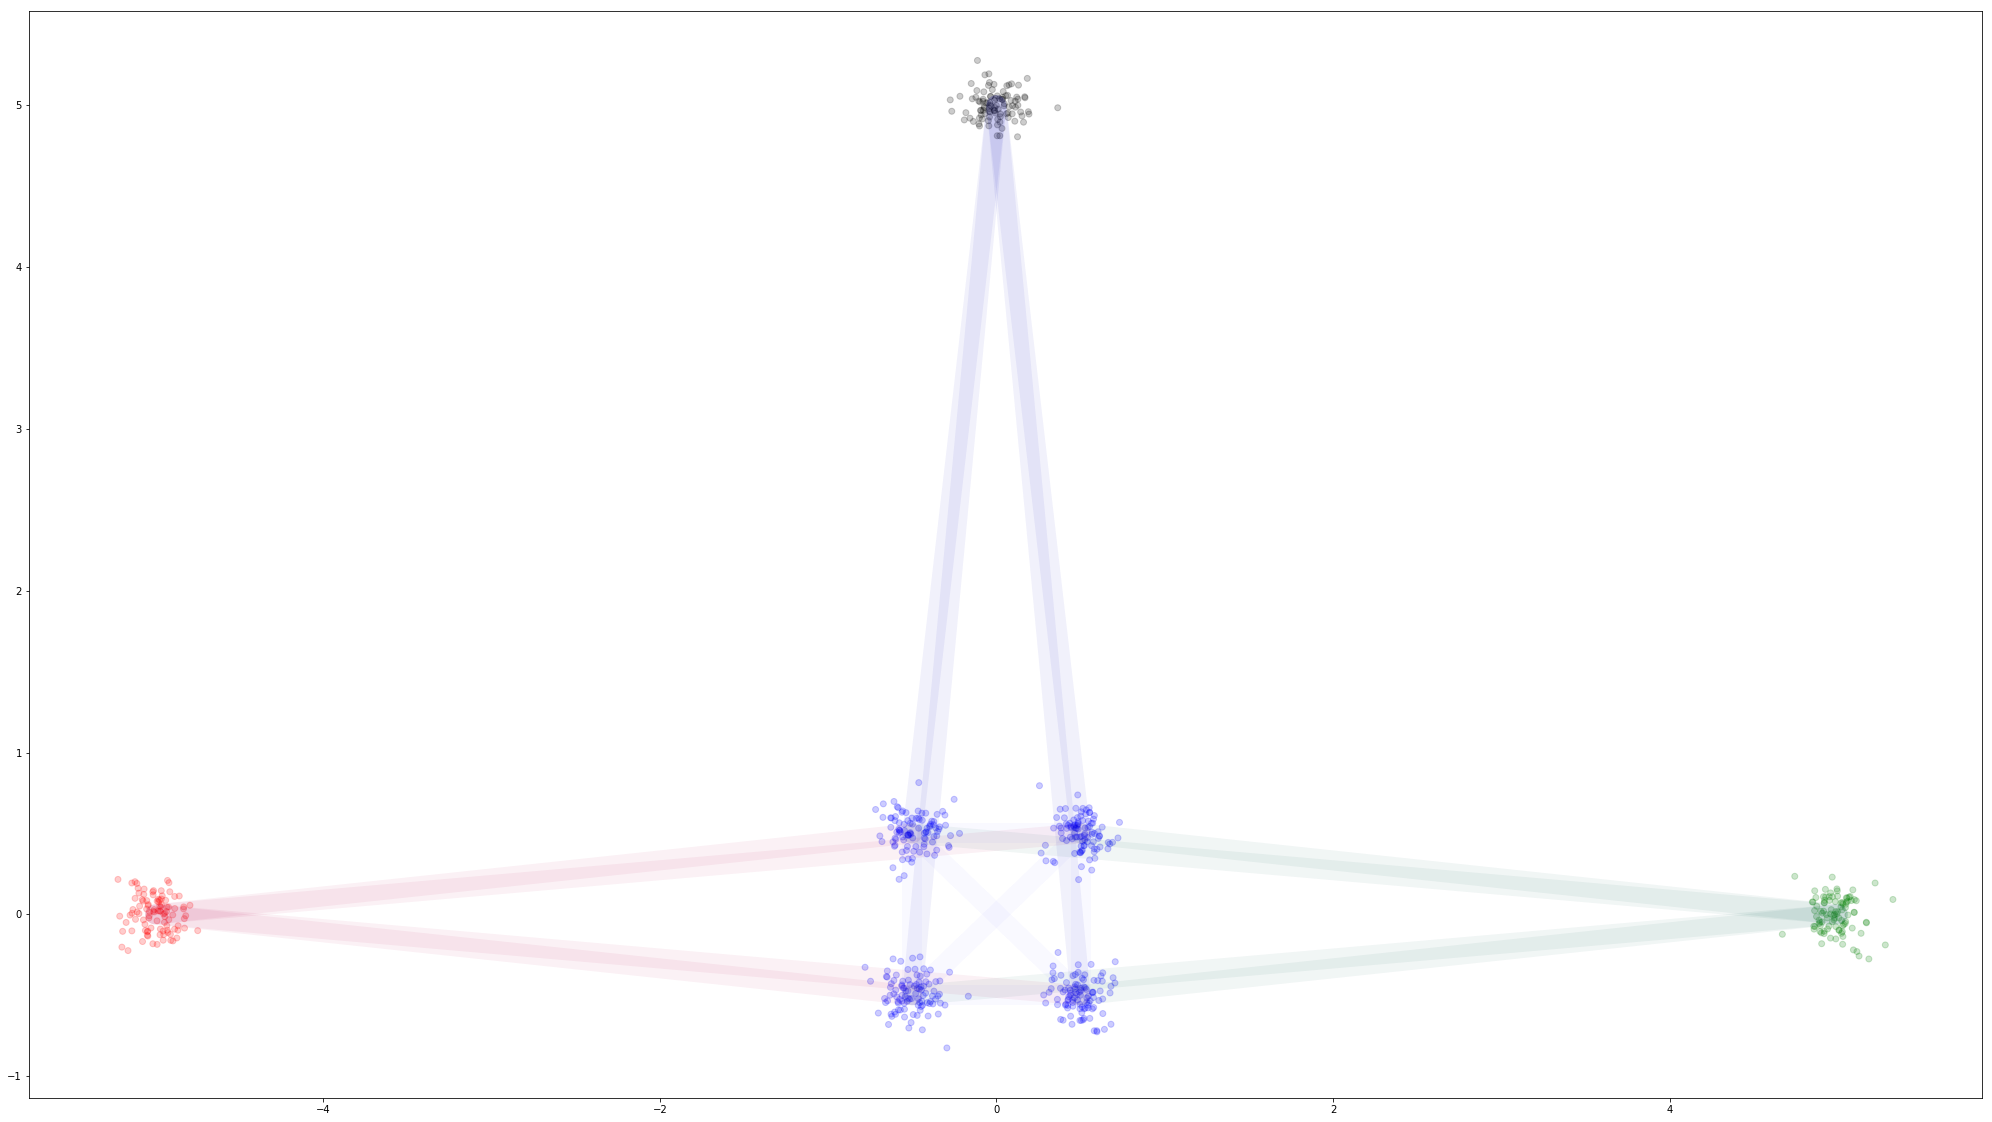

In [7]:


brain = []
neurons_num = 0
neurons_gnw = []
neurons_typ = []
neurons_col = []
neurons_hcc = []
neurons_lay = []
neurons_pos_x = []
neurons_pos_y = []

plt.figure()
for area_idx, area in enumerate(areas):
    region = Region(nam=area, siz=config[area]['siz'], pos=config[area]['pos'], col=config[area]['col'])
    brain.append(region)
    column_idx = 0
    x0, y0 = region.pos
    for x1 in np.arange(-region.siz[0]/2., region.siz[0]/2.):
        for y1 in np.arange(-region.siz[1]/2., region.siz[1]/2.):
            # plt.scatter(x0+x1+0.5, y0+y1+0.5, color=region.col)
            column_idx = column_idx + 1
            neurons_num = neurons_num + (NE+NI)
            neurons_gnw.append([area] * (NE+NI))
            neurons_hcc.append([column_idx] * (NE+NI))
            neurons_typ.append(['E']*NE + ['I']*NI)
            neurons_col.append([config[area]['col']] * (NE+NI))
            neurons_lay.append(['1/2'] * N12 + ['4'] * N4)
            neurons_pos_x.append((x0+x1+0.5) + np.random.randn(NE+NI)/10)
            neurons_pos_y.append((y0+y1+0.5) + np.random.randn(NE+NI)/10)

neurons_gnw = np.array(neurons_gnw).flatten()
neurons_hcc = np.array(neurons_hcc).flatten()
neurons_typ = np.array(neurons_typ).flatten()
neurons_col = np.array(neurons_col).flatten()
neurons_lay = np.array(neurons_lay).flatten()
neurons_pos_x = np.array(neurons_pos_x).flatten()
neurons_pos_y = np.array(neurons_pos_y).flatten()

plt.figure(figsize=[35,20])
plt.scatter(neurons_pos_x, neurons_pos_y, c=neurons_col, alpha=0.2)

for region1 in brain:
    for region2 in brain:
        print("{} <—{}—> {}".format(region1.nam, gconn[region1.nam][region2.nam], region2.nam))
        x01, y01 = region1.pos
        for x1 in np.arange(-region1.siz[0]/2., region1.siz[0]/2.):
            for y1 in np.arange(-region1.siz[1]/2., region1.siz[1]/2.):
                x02, y02 = region2.pos
                for x2 in np.arange(-region2.siz[0]/2., region2.siz[0]/2.):
                    for y2 in np.arange(-region2.siz[1]/2., region2.siz[1]/2.):
                        if region1.nam == region2.nam:
                            regularizer = epsilon/(1. + np.sqrt((x2-x1)**2 + (y2-y1)**2))
                        else:
                            regularizer = 1.
                        plt.plot([x01+x1+0.5, x02+x2+0.5],
                                 [y01+y1+0.5, y02+y2+0.5],
                                 color=region1.col,
                                 linewidth=20,
                                 alpha=(gconn[region1.nam][region2.nam]) * regularizer / 10,
                                 solid_capstyle='round')
plt.show()

### Modèles des neurones et synapses

On décrit vraiment ici les modèles à l'aide d'objets Brian.


In [8]:
# Neuron model

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current

eqs_neurons='''
x : meter
y : meter
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''


# Synapse model
eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

eqs_stdp_exc = '''
w : 1
dApre/dt = -Apre/tau_stdp : 1 (event-driven)
dApost/dt = -Apost/tau_stdp : 1 (event-driven)'''

alpha_s = 4*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight

Création des connections internes aux colonnes

In [9]:
network = Network()

# Initialize neuron group
neurons = NeuronGroup(neurons_num, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
network.add(neurons)
neurons.x = neurons_pos_x * umeter
neurons.y = neurons_pos_y * umeter

con_e = []
con_ii = []
con_ie = []

for region in brain:
    hccs = np.argwhere(neurons_gnw == region.nam) # index of neurons in current area
    hccs_idx = neurons_hcc[hccs].flatten()        # cortical column of all neurons in current area
    hccs_num = np.unique(hccs_idx)                # cortical columns numbers
    for hcc in hccs_num:
        hcc_idx = hccs[np.argwhere(hccs_idx == hcc).flatten()].flatten() # index of neurons in current column
        nstart = hcc_idx[0] # first neuron of the column
        nend = hcc_idx[-1]  #  last neuron of the column
        # Creation of synaptic connection
        con_e.append(Synapses(neurons[nstart:(nstart+NE)], neurons[nstart:nend], on_pre='g_ampa += 0.3*nS'))
        con_e[-1].connect(p=epsilon)
        con_ii.append(Synapses(neurons[(nstart+NE):nend], neurons[(nstart+NE):nend], on_pre='g_gaba += 3*nS'))
        con_ii[-1].connect(p=epsilon)
        # Inhibitory Plasticity
        con_ie.append(Synapses(neurons[(nstart+NE):nend], neurons[nstart:(nstart+NE)], model=eqs_stdp_inhib,
                               on_pre='''Apre += 1.
                                      w = clip(w+(Apost-alpha_s)*eta, 0, gmax)
                                      g_gaba += w*nS''',
                               on_post='''Apost += 1.
                                       w = clip(w+Apre*eta, 0, gmax)
                                    '''))
        con_ie[-1].connect(p=epsilon)
        con_ie[-1].w = 1e-10
        network.add(con_e[-1])
        network.add(con_ii[-1])
        network.add(con_ie[-1])

WARNING    Cannot use Cython, a test compilation failed: Cython is not available (ImportError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Création et connection d'input de bruit (hors architecture, sorte de SpikeGenerator) à la couche 4 des colonnes d'input et d'output du GNW

In [25]:
alpha=0.9

input1 = NeuronGroup(input_size, 'rates: Hz', threshold='rand()<rates*dt')
input2 = NeuronGroup(input_size, 'rates: Hz', threshold='rand()<rates*dt')
result = NeuronGroup(output_size, 'rates: Hz', threshold='rand()<rates*dt')
network.add(input1)
network.add(input2)
network.add(result)

hccs2 = np.argwhere(neurons_gnw == 'Input1')
hccs_idx2 = neurons_hcc[hccs2].flatten()
hccs_num2 = np.unique(hccs_idx2)
for hcc2 in hccs_num2:
    hcc_idx2 = hccs2[np.argwhere(hccs_idx2 == hcc2).flatten()].flatten()
    nstart2 = hcc_idx2[0]
    nend2 = hcc_idx2[-1]
    S1 = Synapses(input1, neurons[(nstart2+N12):(nstart2+NE)], 'w : volt', on_pre='v_post += w')
    S1.connect()
    S1.w = 1e-3 * volt
    network.add(S1)

hccs2 = np.argwhere(neurons_gnw == 'Input2')
hccs_idx2 = neurons_hcc[hccs2].flatten()
hccs_num2 = np.unique(hccs_idx2)
for hcc2 in hccs_num2:
    hcc_idx2 = hccs2[np.argwhere(hccs_idx2 == hcc2).flatten()].flatten()
    nstart2 = hcc_idx2[0]
    nend2 = hcc_idx2[-1]
    S2 = Synapses(input2, neurons[(nstart2+N12):(nstart2+NE)], 'w : volt', on_pre='v_post += w')
    S2.connect()
    S2.w = 1e-3 * volt
    network.add(S2)

hccs2 = np.argwhere(neurons_gnw == 'Output')
hccs_idx2 = neurons_hcc[hccs2].flatten()
hccs_num2 = np.unique(hccs_idx2)
for hcc2 in hccs_num2:
    hcc_idx2 = hccs2[np.argwhere(hccs_idx2 == hcc2).flatten()].flatten()
    nstart2 = hcc_idx2[0]
    nend2 = hcc_idx2[-1]
    S3 = Synapses(result, neurons[(nstart2+N12):(nstart2+NE)], 'w : volt', on_pre='v_post += w')
    S3.connect()
    S3.w = 1e-3 * volt
    network.add(S3)

M1 = SpikeMonitor(input1)
M2 = SpikeMonitor(input2)
O = SpikeMonitor(result)
network.add(M1)
network.add(M2)
network.add(O)

input1.rates = 40 * Hz * (1-alpha)
input2.rates = 40 * Hz * (1-alpha)
result.rates = 40 * Hz * (1-alpha)

0
100
600


### Simulations

In [11]:
sm = SpikeMonitor(neurons)

# without plasticity at all
eta = 0          # Learning rate intra-columnar
eta_cc = 0       # Learning rate inter-columnar
network.add(sm)
network.run(1*second)

# with intra-columnar plasticity only
eta = 1e-1       # Learning rate intra-columnar
eta_cc = 0       # Learning rate inter-columnar
network.run(simtime-1*second, report='text')

WARNING    c:\users\valentin\appdata\local\programs\python\python37-32\lib\site-packages\sympy\matrices\matrices.py:2479: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()
 [py.warnings]


Starting simulation at t=1. s for a duration of 29. s
1.9261799999999998 (6%) simulated in 10s, estimated 2m 21s remaining.
4.1186766666666665 (14%) simulated in 20s, estimated 2m 1s remaining.
6.33592 (21%) simulated in 30s, estimated 1m 47s remaining.
8.577813333333333 (29%) simulated in 40s, estimated 1m 35s remaining.
10.83498 (37%) simulated in 50s, estimated 1m 24s remaining.
13.054640000000001 (45%) simulated in 1m 0s, estimated 1m 13s remaining.
15.315383333333337 (52%) simulated in 1m 10s, estimated 1m 3s remaining.
17.554763333333334 (60%) simulated in 1m 20s, estimated 52s remaining.
19.802166666666665 (68%) simulated in 1m 30s, estimated 42s remaining.
22.02240666666667 (75%) simulated in 1m 40s, estimated 32s remaining.
24.25772666666667 (83%) simulated in 1m 50s, estimated 22s remaining.
26.511703333333337 (91%) simulated in 2m 0s, estimated 11s remaining.
29.0 (100%) simulated in 2m 6s


On affiche les spikes au début (fin de la première seconde), au milieu, et à la fin de la simulation.

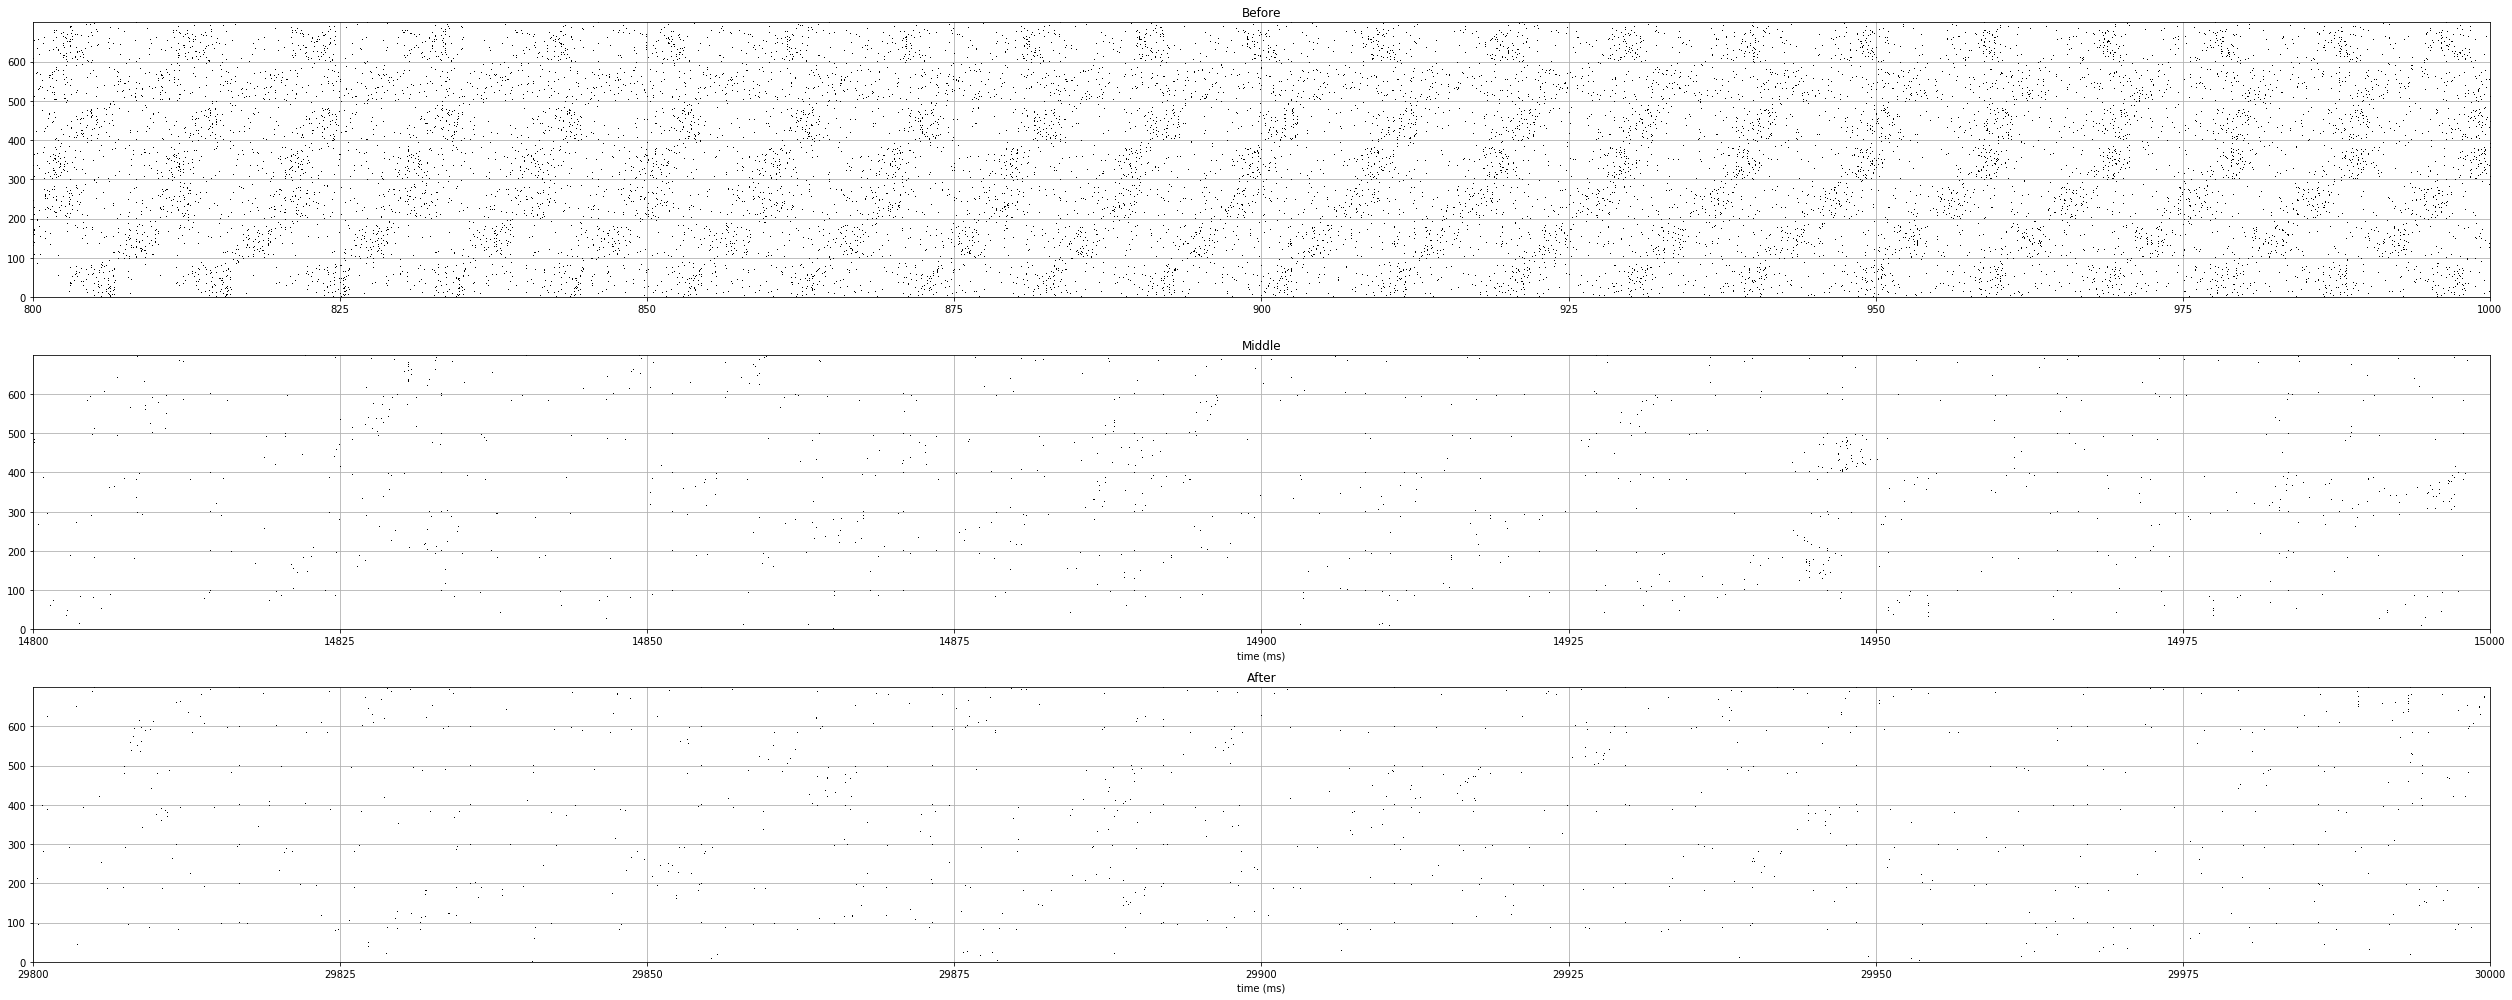

In [12]:
plt.figure(figsize=[35, 14])
i, t = sm.it
subplot(311)
plot(t/ms, i, ',k', ms=0.25)
title("Before")
xlabel("")
yticks([])
xlim(0.8*1e3, 1*1e3)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)

subplot(312)
plot(t/ms, i, ',k', ms=0.25)
xlabel("time (ms)")
yticks([])
title("Middle")
xlim((simtime/2-0.2*second)/ms, simtime/2/ms)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)

subplot(313)
plot(t/ms, i, ',k', ms=0.25)
xlabel("time (ms)")
yticks([])
title("After")
xlim((simtime-0.2*second)/ms, simtime/ms)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)


plt.tight_layout()
show()

Création des connections entre aires et colonnes

In [13]:
con_cc = []
for region1 in brain:
    hccs1 = np.argwhere(neurons_gnw == region1.nam)
    hccs_idx1 = neurons_hcc[hccs1].flatten()
    hccs_num1 = np.unique(hccs_idx1)
    for hcc1 in hccs_num1:
        hcc_idx1 = hccs1[np.argwhere(hccs_idx1 == hcc1).flatten()].flatten()
        nstart1 = hcc_idx1[0]
        nend1 = hcc_idx1[-1]
        for region2 in brain:
            hccs2 = np.argwhere(neurons_gnw == region2.nam)
            hccs_idx2 = neurons_hcc[hccs2].flatten()
            hccs_num2 = np.unique(hccs_idx2)
            for hcc2 in hccs_num2:
                hcc_idx2 = hccs2[np.argwhere(hccs_idx2 == hcc2).flatten()].flatten()
                nstart2 = hcc_idx2[0]
                nend2 = hcc_idx2[-1]
                
                if (region1.nam == region2.nam) and (hcc1 == hcc2):
                    break
                connectivity = gconn[region1.nam][region2.nam]
                print("{} - HCC {} <--{}--> {} - HCC {}".format(region1.nam, hcc1, connectivity, region2.nam, hcc2))
                d = np.sqrt((neurons_pos_x[hccs2].flatten().mean() - neurons_pos_x[hccs1].flatten().mean())**2 +
                            (neurons_pos_y[hccs2].flatten().mean() - neurons_pos_y[hccs1].flatten().mean())**2)

                con_cc.append(Synapses(neurons[nstart1:(nstart1+N12)], neurons[(nstart2+N12):(nstart2+NE)], model=eqs_stdp_exc,        
                                       on_pre='''Apre += 1.
                                              w = clip(w+(Apost-alpha_s)*eta_cc, 0, gmax)
                                              g_ampa += w*nS''',
                                       on_post='''Apost += 1.
                                               w = clip(w+Apre*eta_cc, 0, gmax)
                                               ''',
                                       delay=d*ms))

                con_cc[-1].connect(p=connectivity)
                network.add(con_cc[-1])
        print('\n')

Input1 - HCC 1 <--0.0--> Input2 - HCC 1
Input1 - HCC 1 <--0.4--> Kernel - HCC 1
Input1 - HCC 1 <--0.4--> Kernel - HCC 2
Input1 - HCC 1 <--0.4--> Kernel - HCC 3
Input1 - HCC 1 <--0.4--> Kernel - HCC 4
Input1 - HCC 1 <--0.0--> Output - HCC 1


Input2 - HCC 1 <--0.0--> Input1 - HCC 1
Input2 - HCC 1 <--0.4--> Kernel - HCC 1
Input2 - HCC 1 <--0.4--> Kernel - HCC 2
Input2 - HCC 1 <--0.4--> Kernel - HCC 3
Input2 - HCC 1 <--0.4--> Kernel - HCC 4
Input2 - HCC 1 <--0.0--> Output - HCC 1


Kernel - HCC 1 <--0.15--> Input1 - HCC 1
Kernel - HCC 1 <--0.15--> Input2 - HCC 1
Kernel - HCC 1 <--0.4--> Output - HCC 1


Kernel - HCC 2 <--0.15--> Input1 - HCC 1
Kernel - HCC 2 <--0.15--> Input2 - HCC 1
Kernel - HCC 2 <--0.5--> Kernel - HCC 1
Kernel - HCC 2 <--0.4--> Output - HCC 1


Kernel - HCC 3 <--0.15--> Input1 - HCC 1
Kernel - HCC 3 <--0.15--> Input2 - HCC 1
Kernel - HCC 3 <--0.5--> Kernel - HCC 1
Kernel - HCC 3 <--0.5--> Kernel - HCC 2
Kernel - HCC 3 <--0.4--> Output - HCC 1


Kernel - HCC 4 <--0.15--

In [14]:
# with intra-columnar plasticity only
eta = 1e-1       # Learning rate intra-columnar
eta_cc = 0       # Learning rate inter-columnar
network.run(1*second)
# with both intra-columnar & inter-columnar plasticity
eta = 1e-1       # Learning rate intra-columnar
eta_cc = 1e-1       # Learning rate inter-columnar
network.run(simtime-1*second, report='text')

WARNING    c:\users\valentin\appdata\local\programs\python\python37-32\lib\site-packages\sympy\matrices\matrices.py:2479: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()
 [py.warnings]


Starting simulation at t=31. s for a duration of 29. s
0.5085150000000014 (1%) simulated in 10s, estimated 9m 20s remaining.
1.016401666666666 (3%) simulated in 20s, estimated 9m 11s remaining.
1.5259800000000014 (5%) simulated in 30s, estimated 9m 0s remaining.
2.0347366666666673 (7%) simulated in 40s, estimated 8m 50s remaining.
2.5381766666666685 (8%) simulated in 50s, estimated 8m 41s remaining.
3.033061666666667 (10%) simulated in 1m 0s, estimated 8m 34s remaining.
3.5190050000000013 (12%) simulated in 1m 10s, estimated 8m 27s remaining.
4.029018333333334 (13%) simulated in 1m 20s, estimated 8m 16s remaining.
4.5372433333333335 (15%) simulated in 1m 30s, estimated 8m 5s remaining.
5.026618333333335 (17%) simulated in 1m 40s, estimated 7m 57s remaining.
5.513480000000001 (19%) simulated in 1m 50s, estimated 7m 49s remaining.
5.996378333333334 (20%) simulated in 2m 0s, estimated 7m 40s remaining.
6.479228333333335 (22%) simulated in 2m 10s, estimated 7m 32s remaining.
6.965896666666

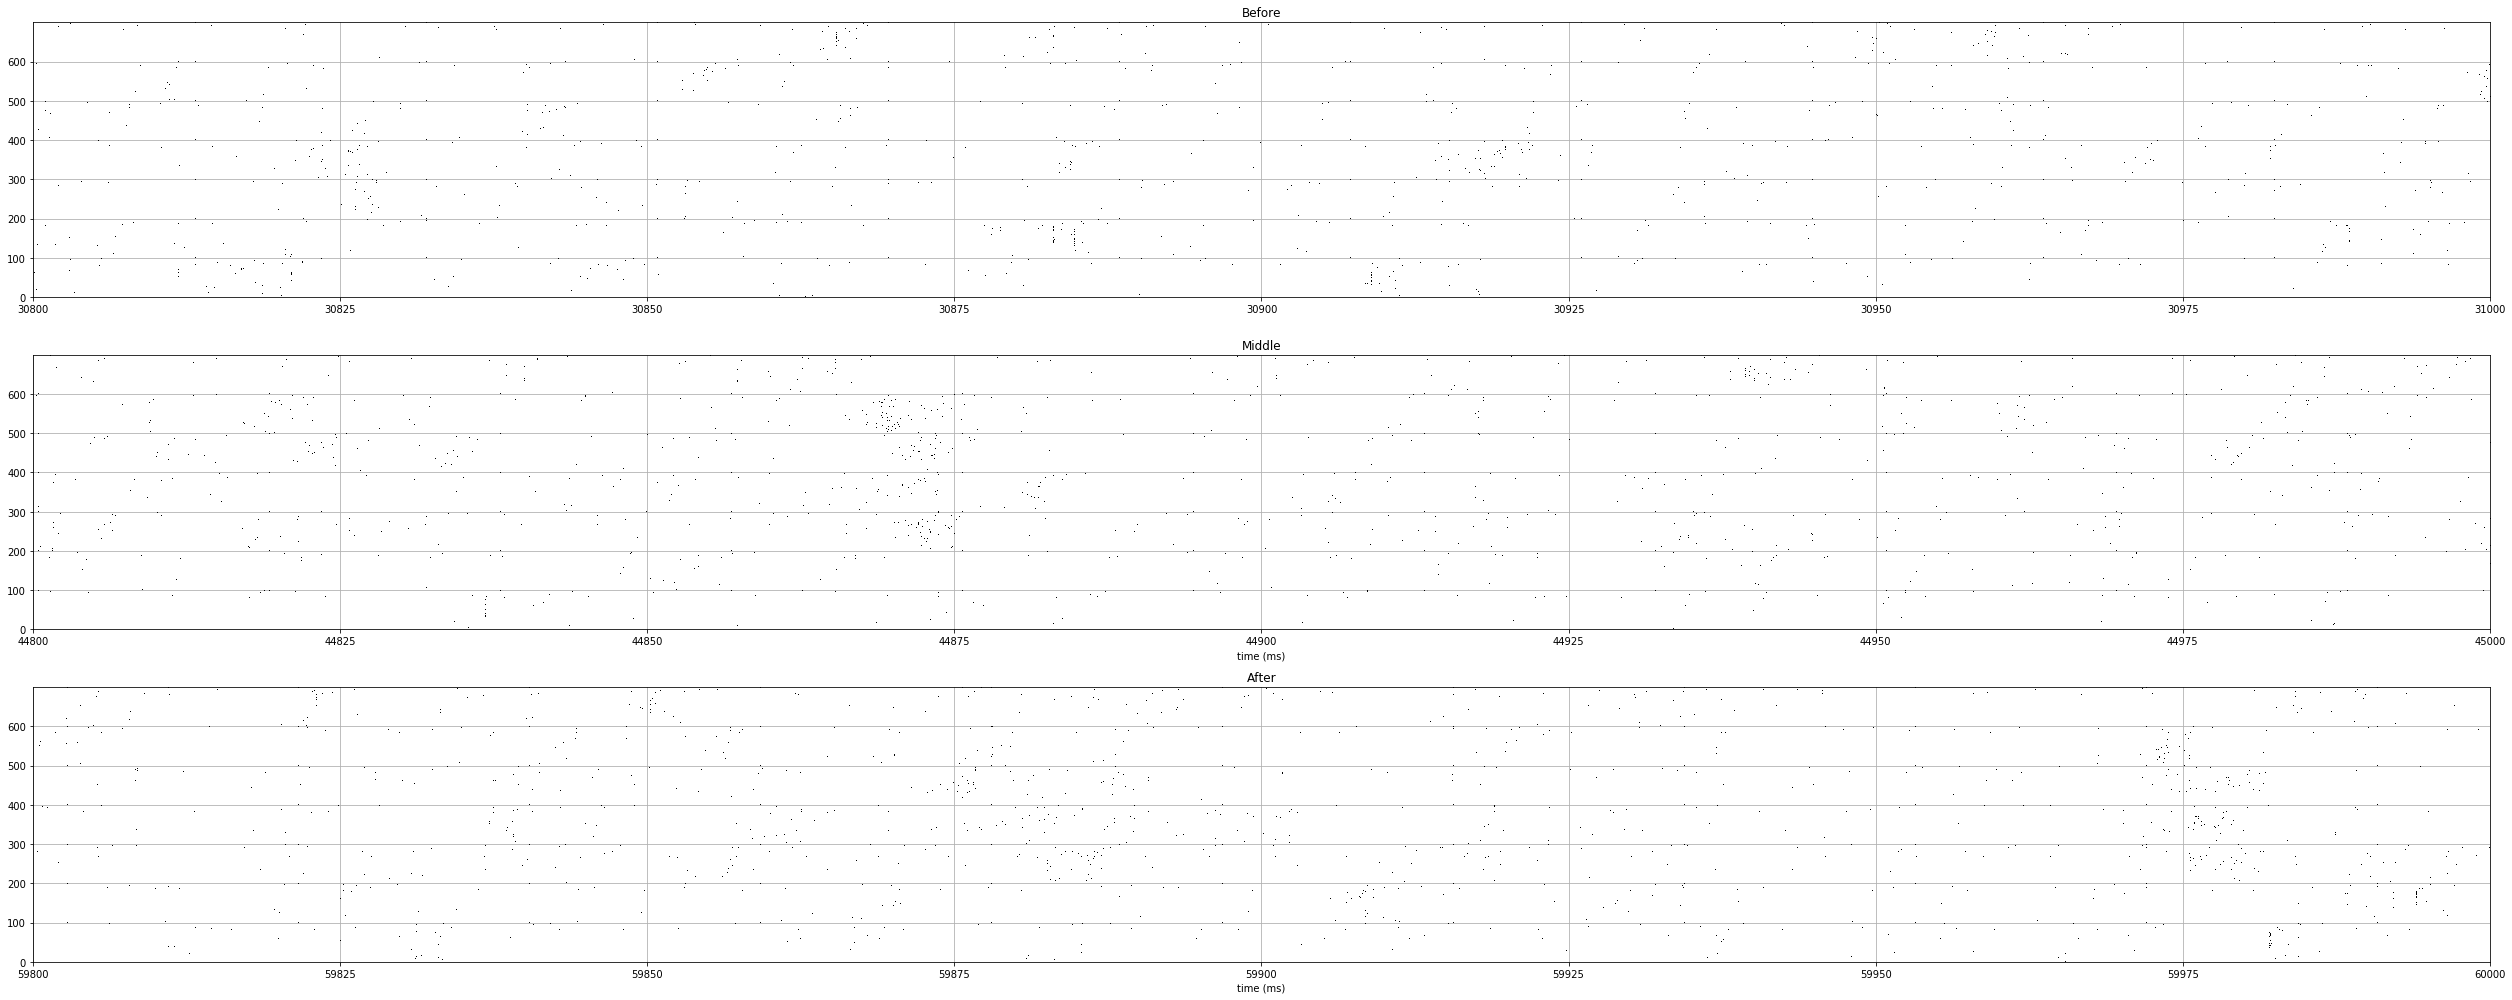

In [15]:
plt.figure(figsize=[35, 14])
i, t = sm.it

subplot(311)
plot(t/ms, i, ',k', ms=0.25)
title("Before")
xlabel("")
yticks([])
xlim((simtime + 0.8*second)/ms, simtime/ms + 1*1e3)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)

subplot(312)
plot(t/ms, i, ',k', ms=0.25)
xlabel("time (ms)")
yticks([])
title("Middle")
xlim((3/2*simtime - 0.2*second)/ms, 3/2*simtime/ms)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)

subplot(313)
plot(t/ms, i, ',k', ms=0.25)
xlabel("time (ms)")
yticks([])
title("After")
xlim((2*simtime - 0.2*second)/ms, 2 * simtime/ms)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)


plt.tight_layout()
show()

In [16]:
# with both intra-columnar & inter-columnar plasticity
eta = 1e-1       # Learning rate intra-columnar
eta_cc = 1e-1       # Learning rate inter-columnar
network.run(1*second)
# with inter-columnar plasticity only
eta = 0       # Learning rate intra-columnar
eta_cc = 1e-1       # Learning rate inter-columnar
network.run(simtime-1*second, report='text')

WARNING    c:\users\valentin\appdata\local\programs\python\python37-32\lib\site-packages\sympy\matrices\matrices.py:2479: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()
 [py.warnings]


Starting simulation at t=61. s for a duration of 29. s
0.3131677777777794 (1%) simulated in 10s, estimated 15m 16s remaining.
0.6288488888888909 (2%) simulated in 20s, estimated 15m 2s remaining.
0.9346055555555558 (3%) simulated in 30s, estimated 15m 1s remaining.
1.238686666666667 (4%) simulated in 40s, estimated 14m 56s remaining.
1.540447777777781 (5%) simulated in 50s, estimated 14m 51s remaining.
1.8275800000000013 (6%) simulated in 1m 0s, estimated 14m 52s remaining.
2.107204444444447 (7%) simulated in 1m 10s, estimated 14m 53s remaining.
2.385056666666666 (8%) simulated in 1m 20s, estimated 14m 53s remaining.
2.6443811111111106 (9%) simulated in 1m 30s, estimated 14m 57s remaining.
2.8904944444444447 (9%) simulated in 1m 40s, estimated 15m 3s remaining.
3.1297766666666655 (10%) simulated in 1m 50s, estimated 15m 9s remaining.
3.3529799999999996 (11%) simulated in 2m 0s, estimated 15m 18s remaining.
3.5458622222222234 (12%) simulated in 2m 10s, estimated 15m 33s remaining.
3.727

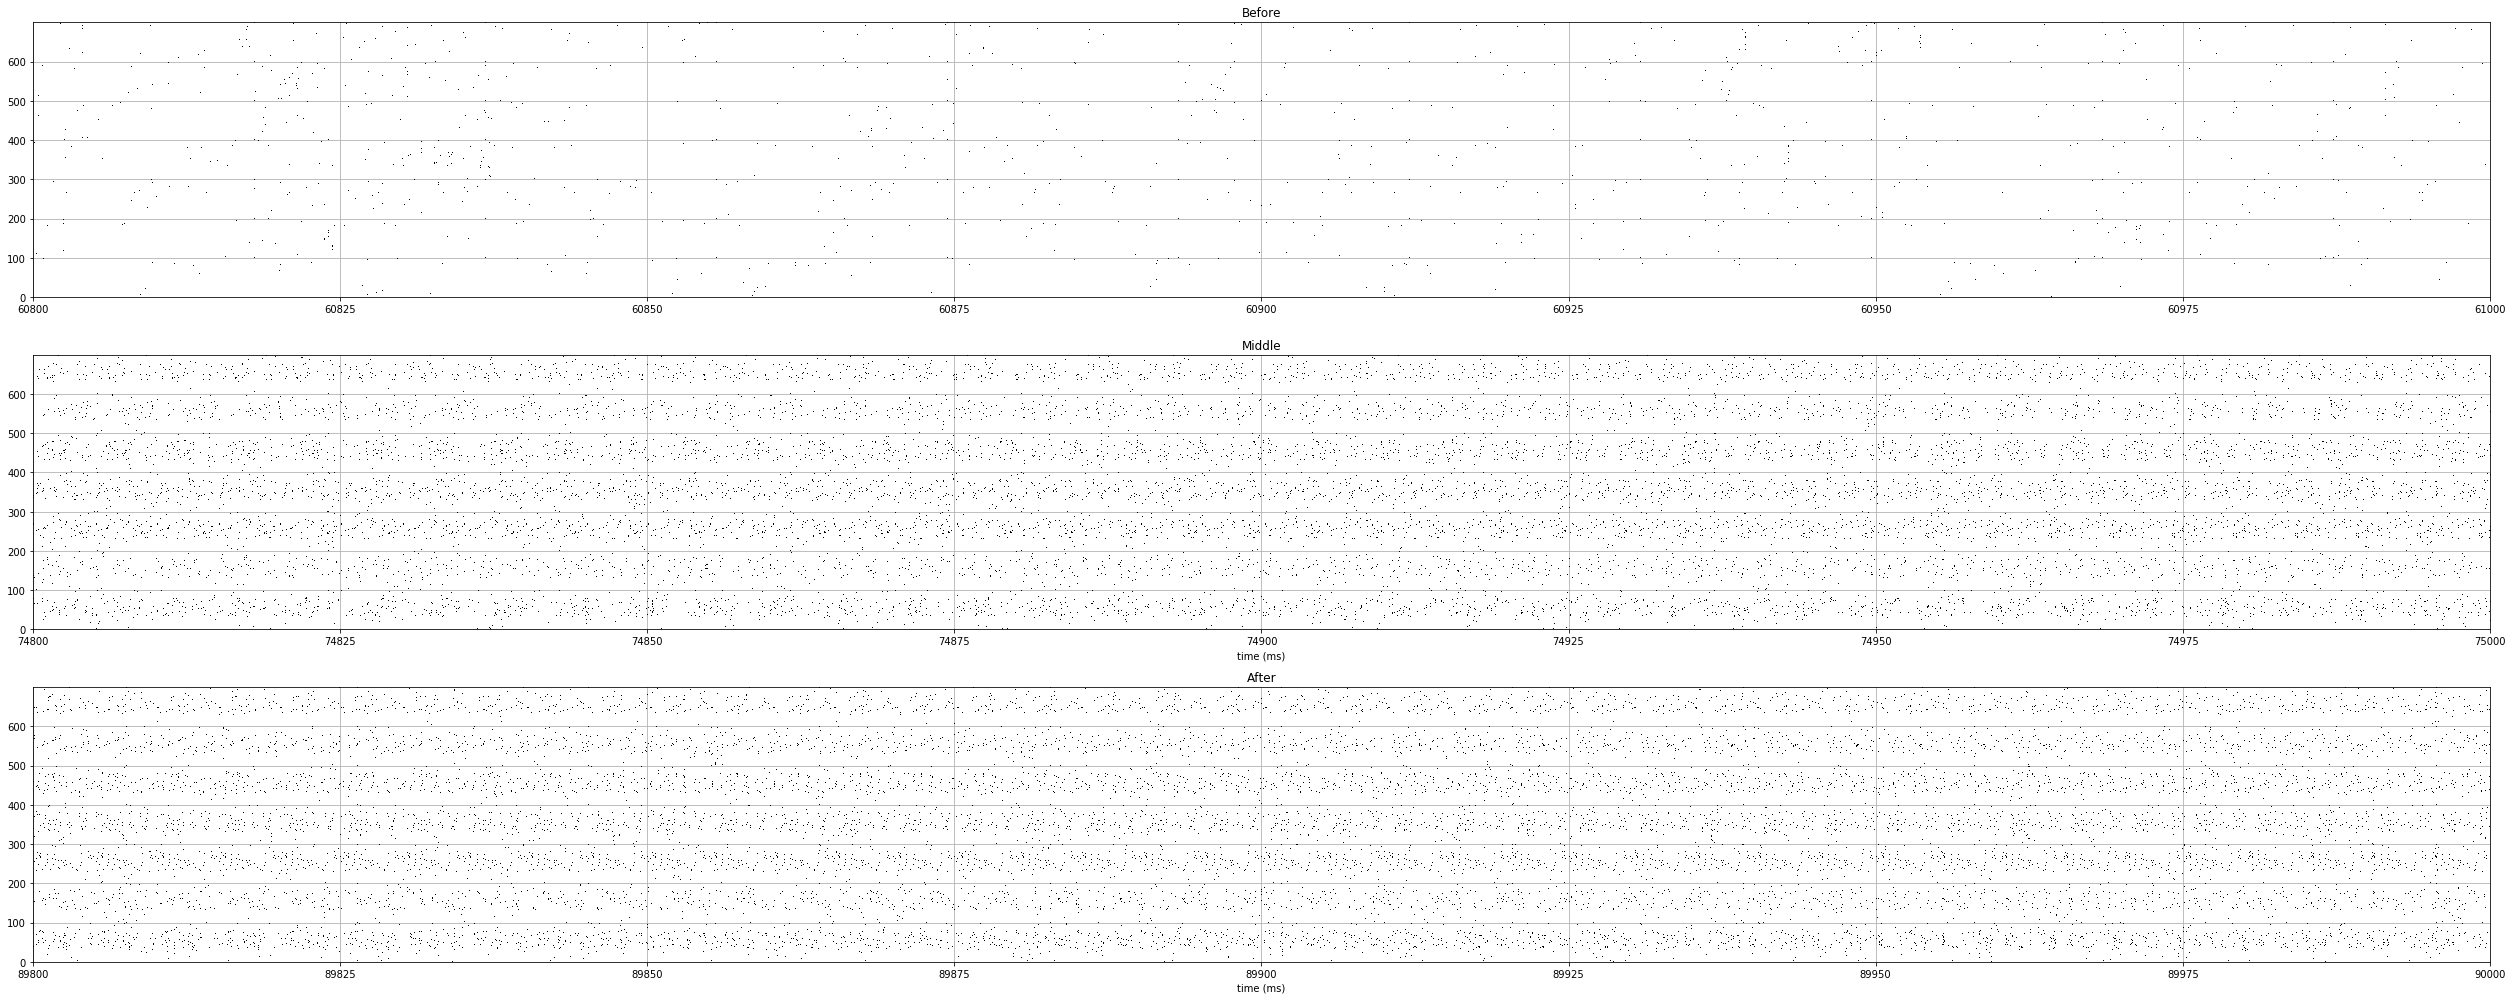

In [17]:
plt.figure(figsize=[35, 14])
i, t = sm.it

subplot(311)
plot(t/ms, i, ',k', ms=0.25)
title("Before")
xlabel("")
yticks([])
xlim((2*simtime + 0.8*second)/ms, 2*simtime/ms + 1*1e3)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)

subplot(312)
plot(t/ms, i, ',k', ms=0.25)
xlabel("time (ms)")
yticks([])
title("Middle")
xlim((5/2*simtime - 0.2*second)/ms, 5/2*simtime/ms)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)

subplot(313)
plot(t/ms, i, ',k', ms=0.25)
xlabel("time (ms)")
yticks([])
title("After")
xlim((3*simtime - 0.2*second)/ms, 3 * simtime/ms)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)


plt.tight_layout()
show()

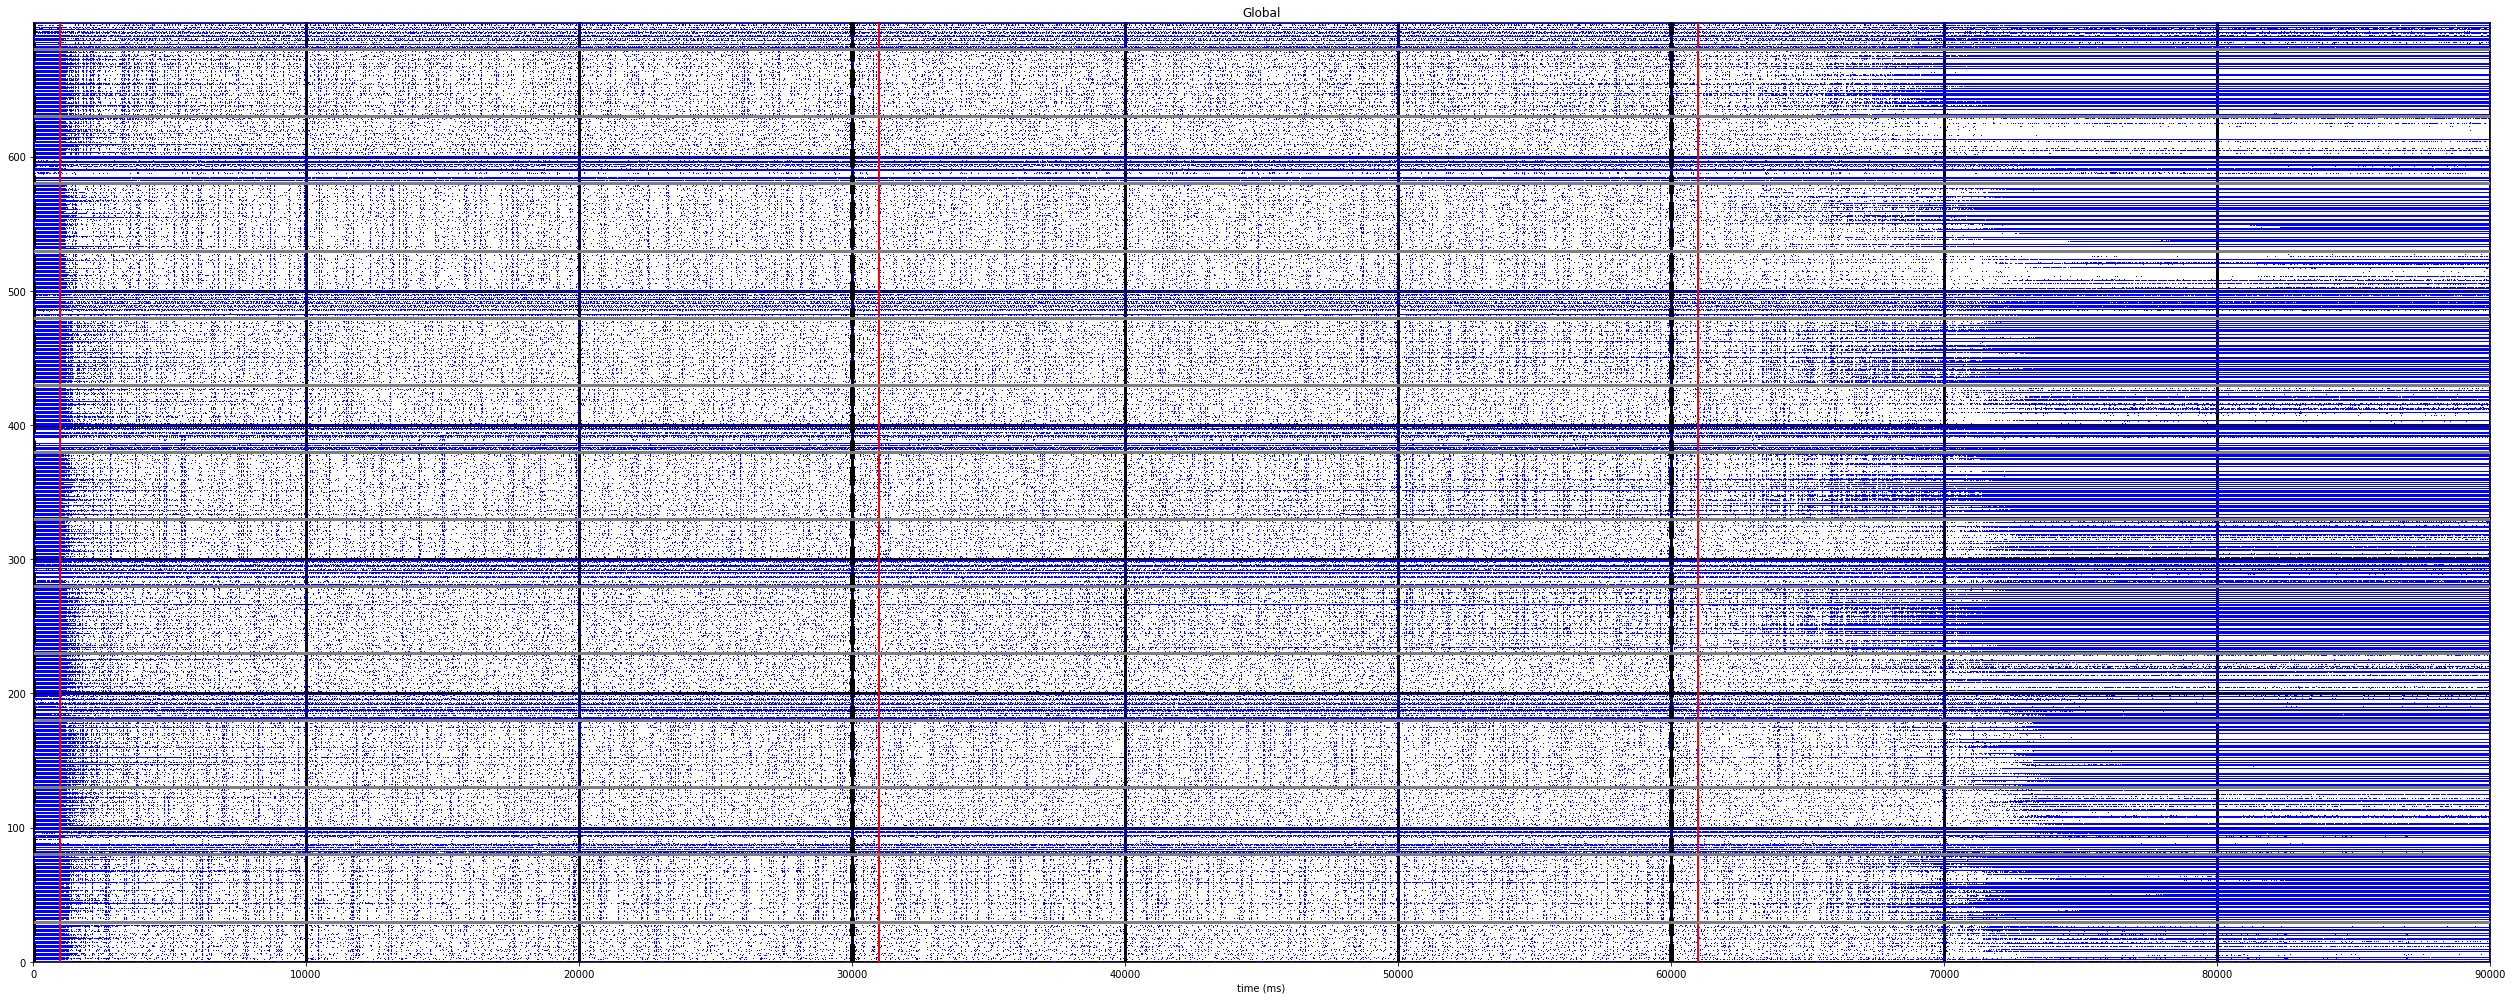

In [18]:
figure(figsize=[35,7*2])
plot(t/ms, i, ',b', ms=0.25)
xlabel("time (ms)")
yticks([])
title("Global")
plt.plot([0*simtime/ms, 0*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([1*simtime/ms, 1*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([2*simtime/ms, 2*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([0*simtime/ms + 1000, 0*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([1*simtime/ms + 1000, 1*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([2*simtime/ms + 1000, 2*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)

for column in range(7):
    plt.plot([0, 3*simtime/ms], [column*column_size+NE, column*column_size+NE], 'grey', linewidth=3)
    plt.plot([0, 3*simtime/ms], [column*column_size+N12, column*column_size+N12], 'grey', linewidth=3)

xlim(0, 3*simtime/ms)
ylim(0, neurons_num)

plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True, linestyle='-', linewidth=3, color='k')
plt.tight_layout()
show()

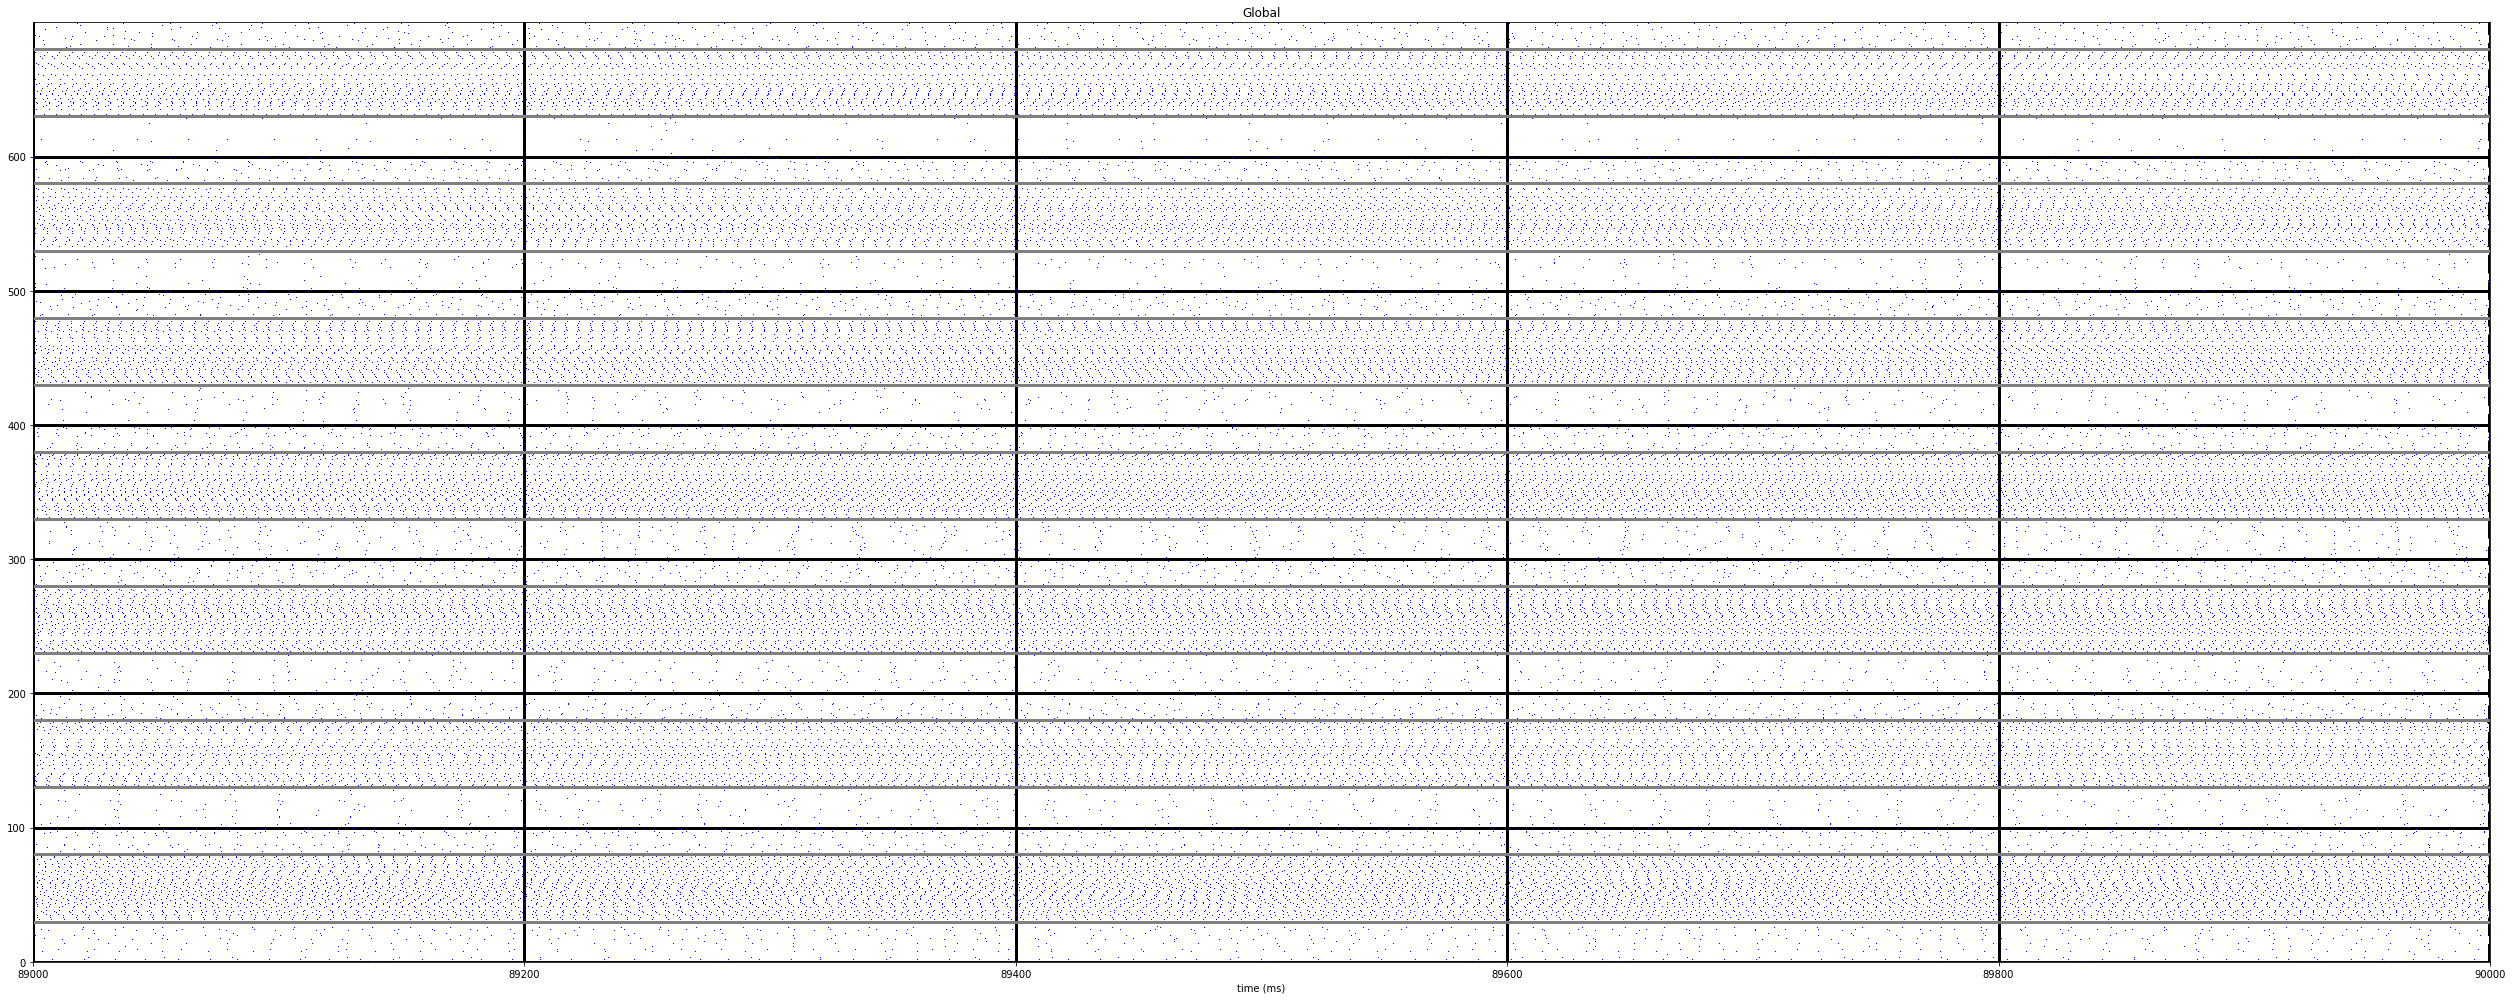

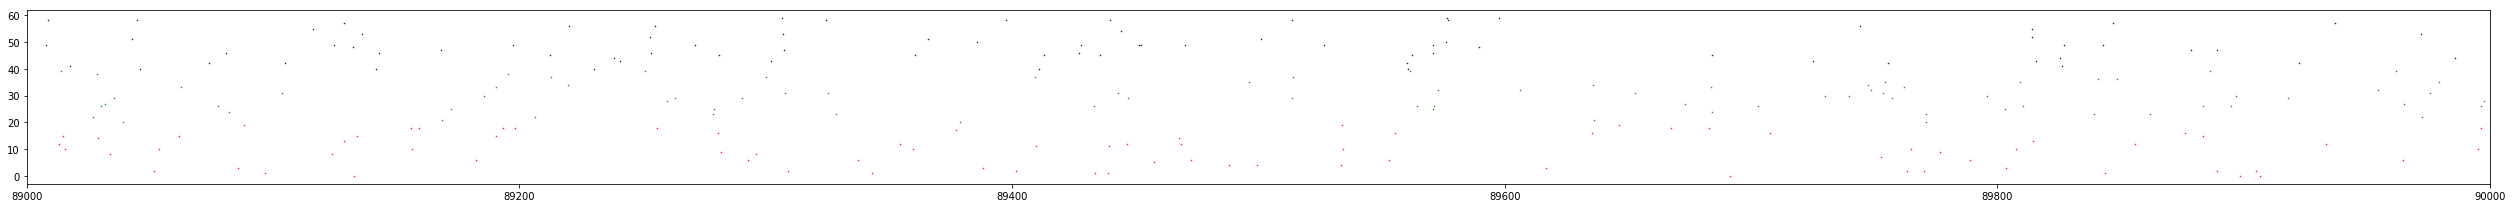

In [19]:
figure(figsize=[35,7*2])
plot(t/ms, i, ',b', ms=0.25)
xlabel("time (ms)")
yticks([])
title("Global")
plt.plot([0*simtime/ms, 0*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([1*simtime/ms, 1*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([2*simtime/ms, 2*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([3*simtime/ms, 3*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([0*simtime/ms + 1000, 0*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([1*simtime/ms + 1000, 1*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([2*simtime/ms + 1000, 2*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([3*simtime/ms + 1000, 3*simtime/ms + 1000], [0, neurons_num], 'g', linewidth=2)

for column in range(7):
    plt.plot([0, 3*simtime/ms], [column*column_size+NE, column*column_size+NE], 'grey', linewidth=3)
    plt.plot([0, 3*simtime/ms], [column*column_size+N12, column*column_size+N12], 'grey', linewidth=3)

xlim(3*simtime/ms-1000, 3*simtime/ms)
ylim(0, neurons_num)

plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True, linestyle='-', linewidth=3, color='k')
plt.tight_layout()
show()

figure(figsize=[35,3])
plot(M1.t/ms, M1.i, '.r', markersize=1)
plot(M2.t/ms, input_size+M2.i, '.g', markersize=1)
plot(O.t/ms, input_size+output_size+O.i, '.k', markersize=1)
xlim(3*simtime/ms-1000, 3*simtime/ms)
plt.tight_layout()
show()

In [20]:
in1 = []
in2 = []
out = []
for stim in tqdm_notebook(range(int(simtime/4/second))):
    value1 = np.random.randint(low=0, high=2)
    value2 = np.random.randint(low=0, high=2)
    in1.append(value1)
    in2.append(value2)
    out.append(value1 != value2)
    
    input1.rates = 40 * Hz * (alpha * value1 + (1-alpha))
    input2.rates = 40 * Hz * (alpha * value2 + (1-alpha))
    if (value1 != value2):
        result.rates = 40 * Hz * alpha
    else:
        result.rates = 40 * Hz * (1-alpha)
    network.run(3*second)

    input1.rates = 40 * Hz * (1-alpha)
    input2.rates = 40 * Hz * (1-alpha)  
    result.rates = 40 * Hz * (1-alpha)
    network.run(1*second)

WARNING    c:\users\valentin\appdata\local\programs\python\python37-32\lib\site-packages\sympy\matrices\matrices.py:2479: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()
 [py.warnings]


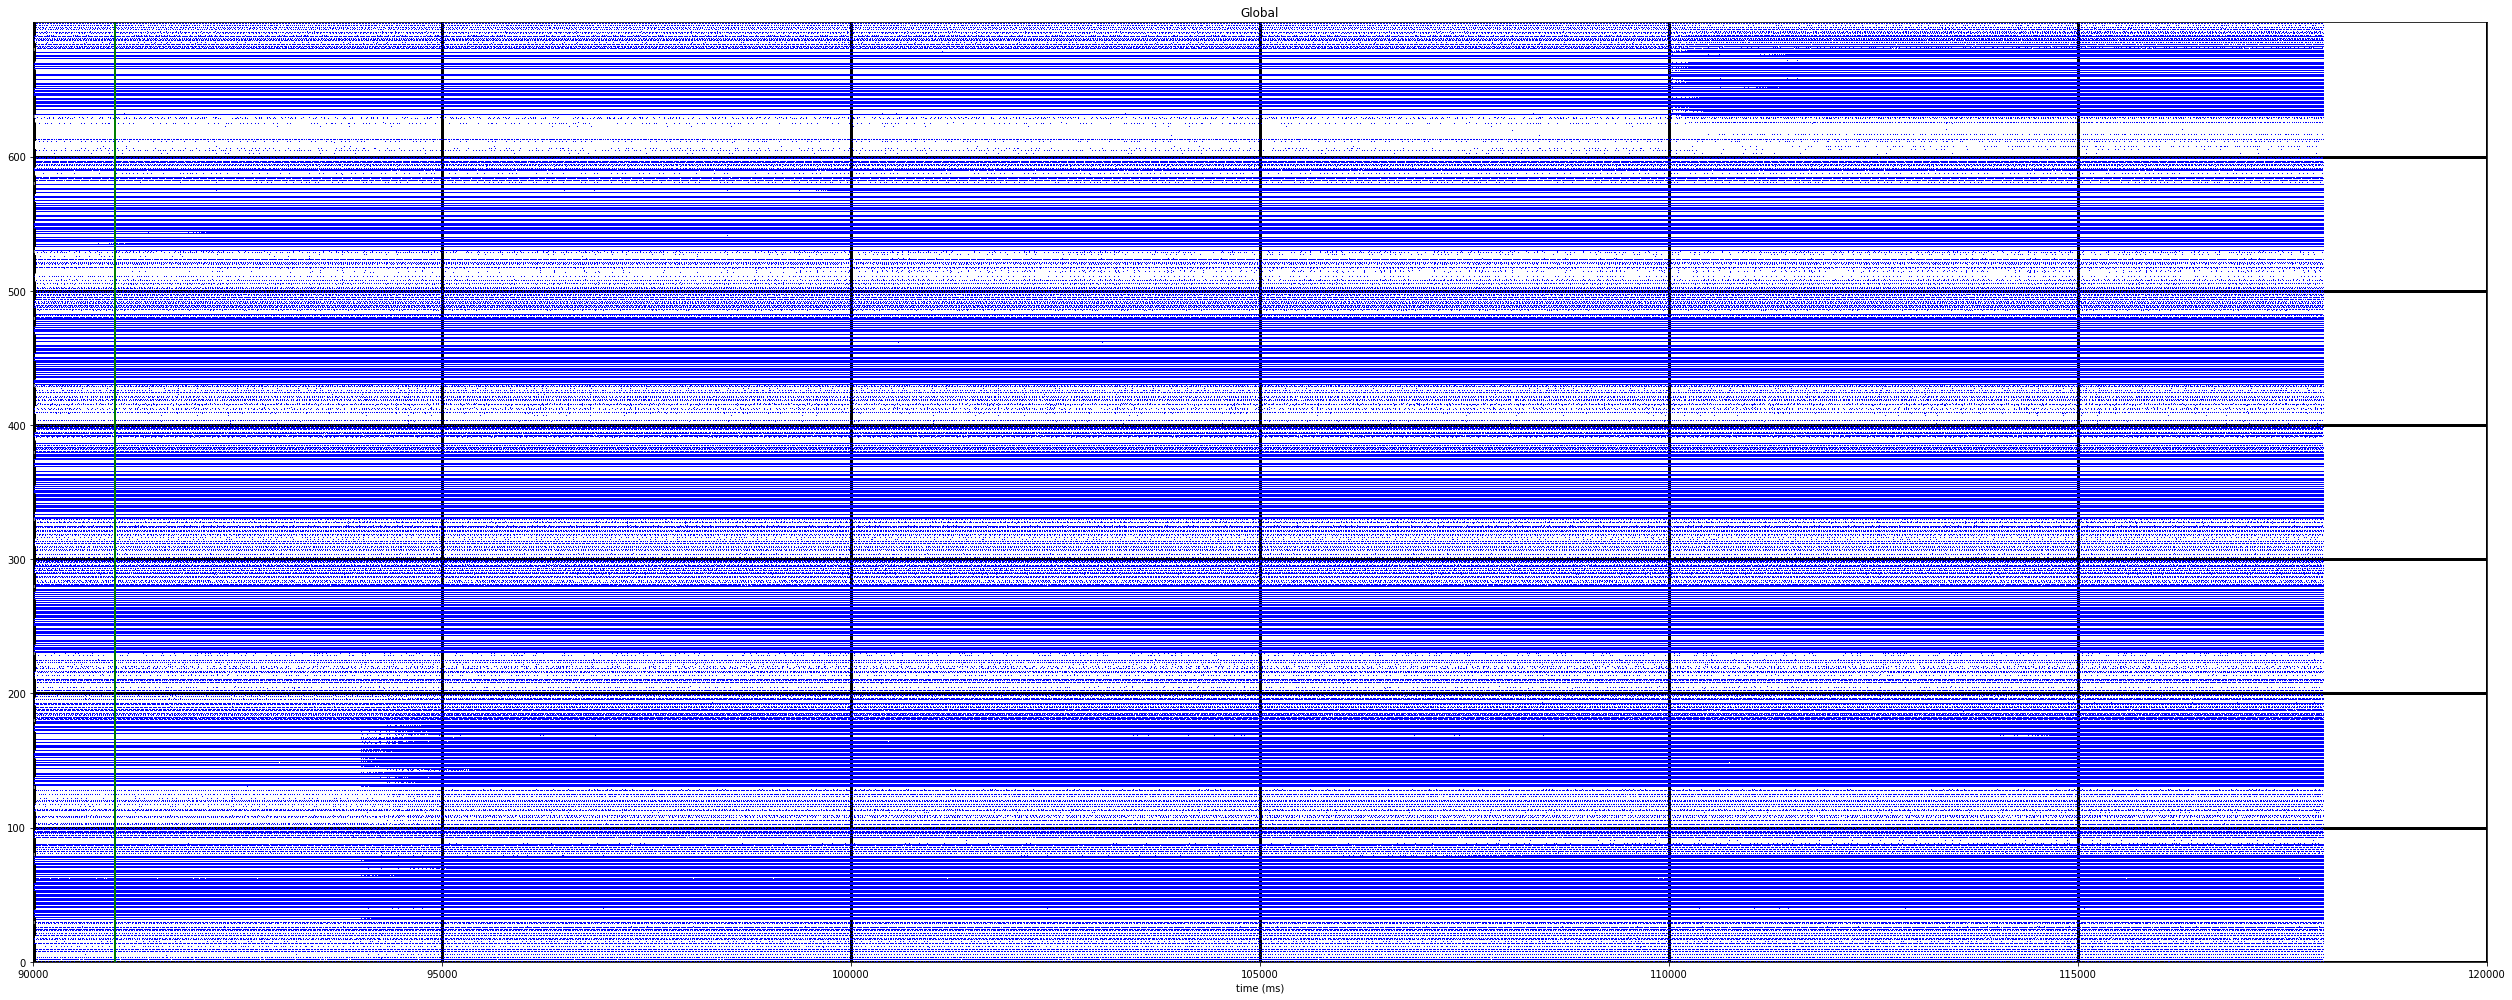

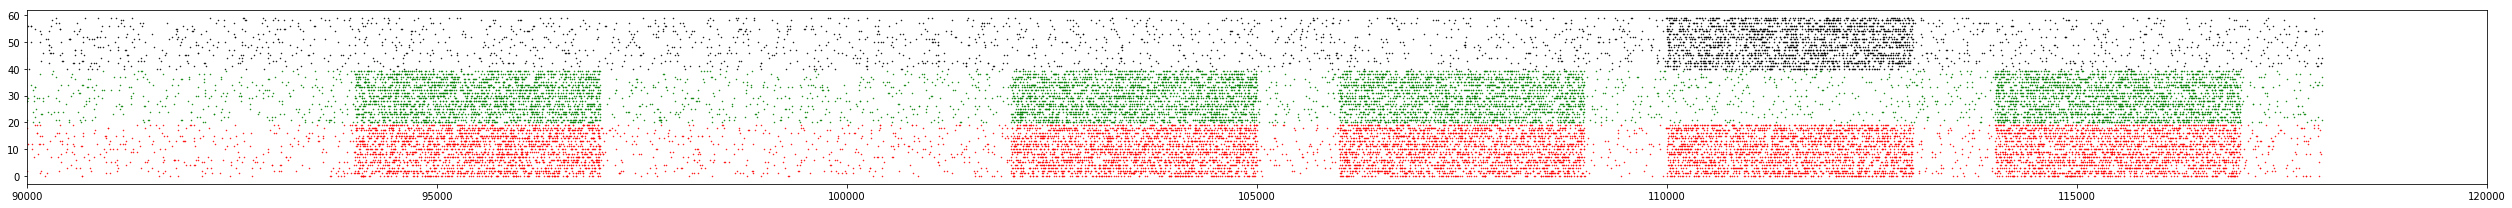

In [21]:
figure(figsize=[35,7*2])
plot(t/ms, i, ',b', ms=0.25)
xlabel("time (ms)")
yticks([])
title("Global")
plt.plot([0*simtime/ms, 0*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([1*simtime/ms, 1*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([2*simtime/ms, 2*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([3*simtime/ms, 3*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([0*simtime/ms + 1000, 0*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([1*simtime/ms + 1000, 1*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([2*simtime/ms + 1000, 2*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([3*simtime/ms + 1000, 3*simtime/ms + 1000], [0, neurons_num], 'g', linewidth=2)

for column in range(7):
    plt.plot([0, 3*simtime/ms], [column*column_size+NE, column*column_size+NE], 'grey', linewidth=3)
    plt.plot([0, 3*simtime/ms], [column*column_size+N12, column*column_size+N12], 'grey', linewidth=3)

xlim(3*simtime/ms, 4*simtime/ms)
ylim(0, neurons_num)

plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True, linestyle='-', linewidth=3, color='k')
plt.tight_layout()
show()

figure(figsize=[35,3])
plot(M1.t/ms, M1.i, '.r', markersize=1)
plot(M2.t/ms, input_size+M2.i, '.g', markersize=1)
plot(O.t/ms, input_size+output_size+O.i, '.k', markersize=1)
xlim(3*simtime/ms, 4*simtime/ms)
plt.tight_layout()
show()

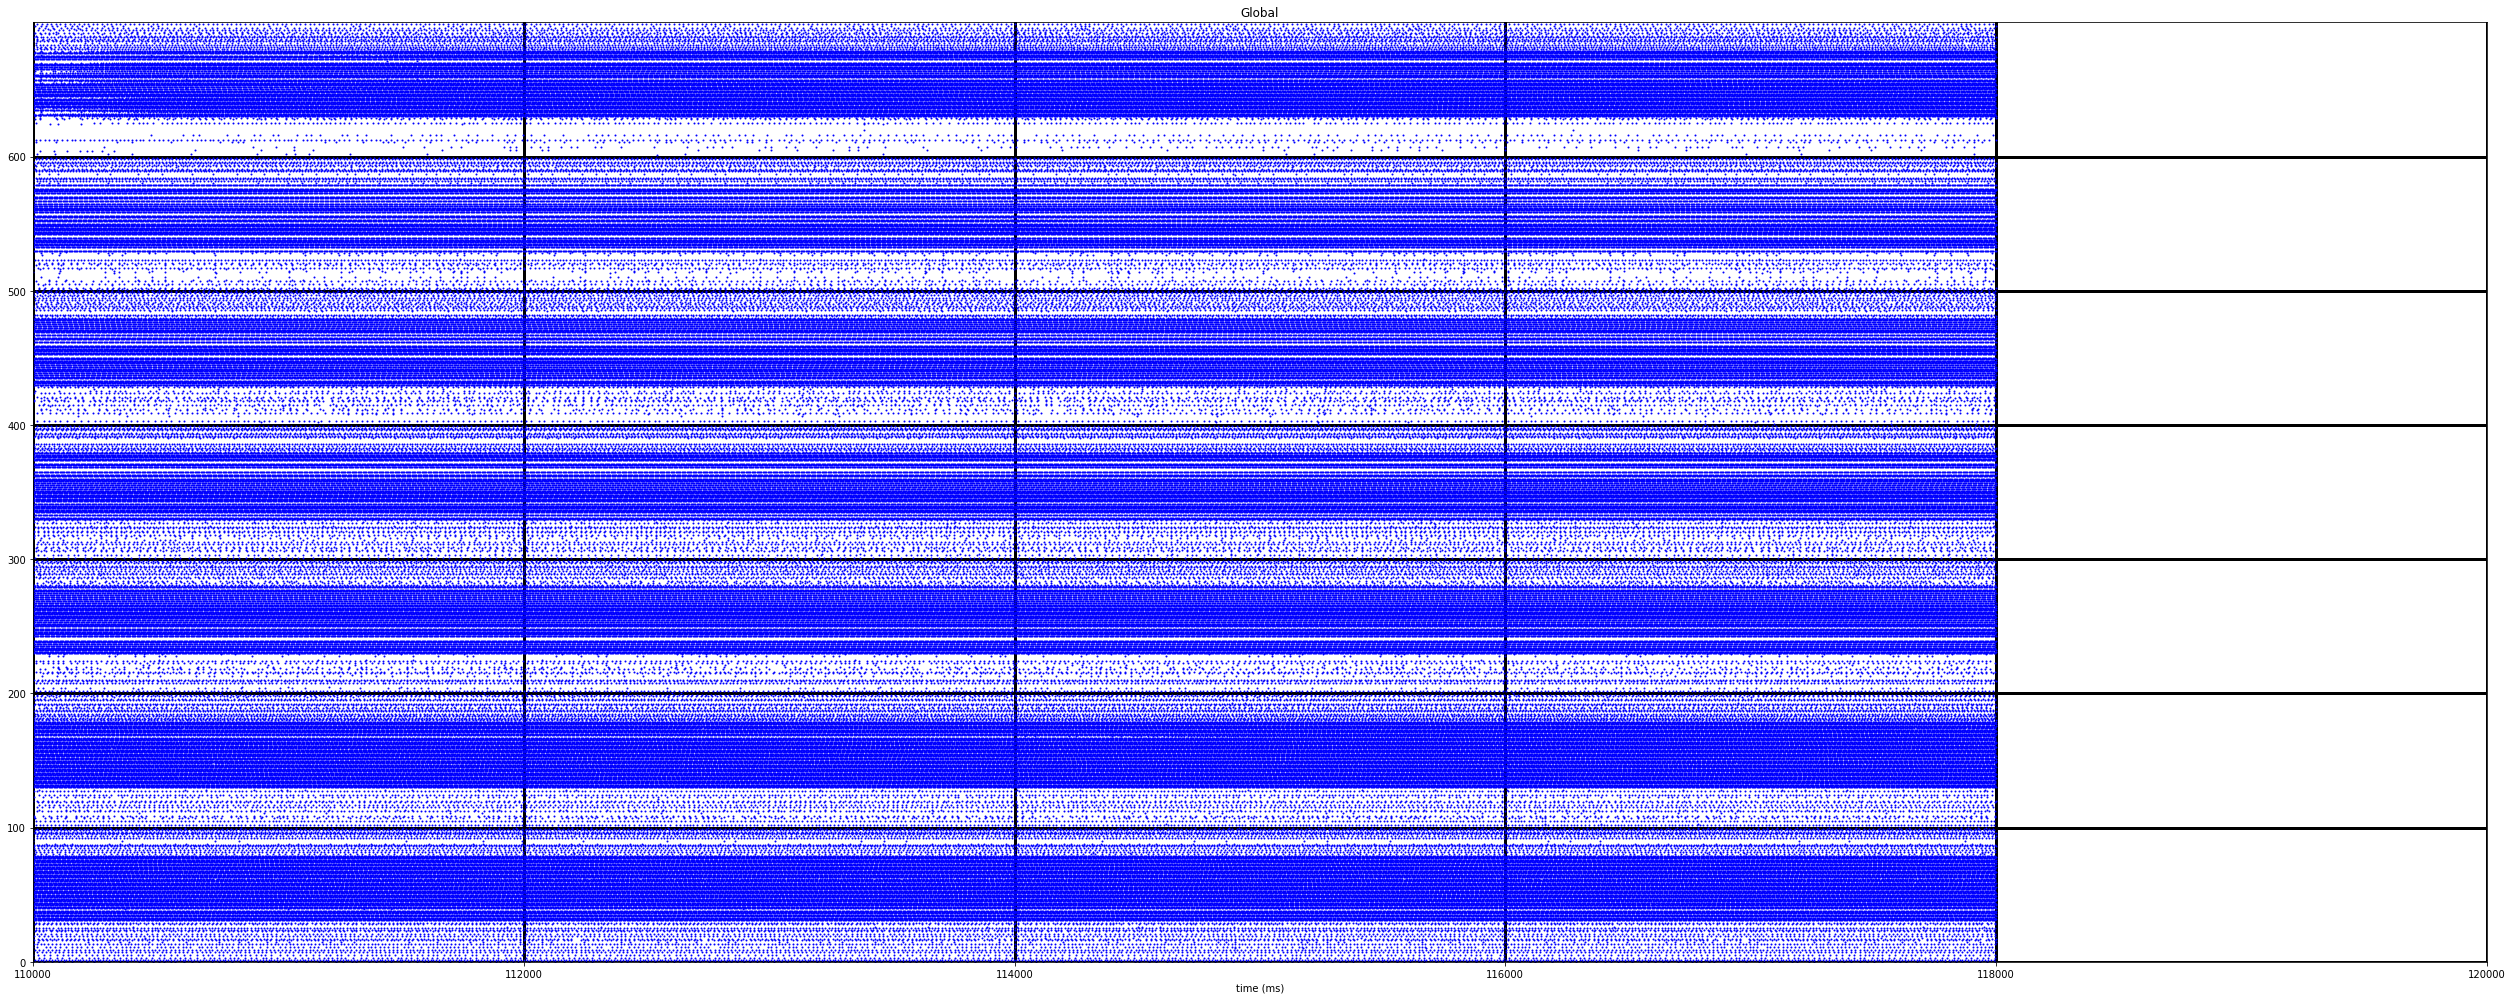

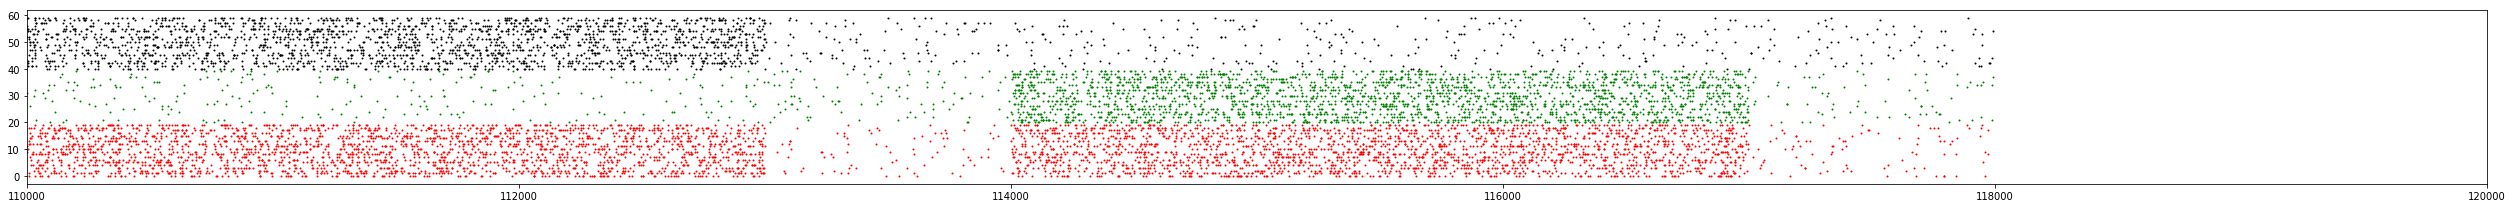

In [22]:
figure(figsize=[35,7*2])

tmin = 4*simtime/ms-10000
tmax = tmin + 10000

sel = np.argwhere((t/ms >= tmin) * (t/ms <= tmax))

plot(t[sel]/ms, i[sel], '.b', markersize=2)
xlabel("time (ms)")
yticks([])
title("Global")
plt.plot([0*simtime/ms, 0*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([1*simtime/ms, 1*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([2*simtime/ms, 2*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([3*simtime/ms, 3*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([0*simtime/ms + 1000, 0*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([1*simtime/ms + 1000, 1*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([2*simtime/ms + 1000, 2*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([3*simtime/ms + 1000, 3*simtime/ms + 1000], [0, neurons_num], 'g', linewidth=2)

for column in range(7):
    plt.plot([0, 3*simtime/ms], [column*column_size+NE, column*column_size+NE], 'grey', linewidth=3)
    plt.plot([0, 3*simtime/ms], [column*column_size+N12, column*column_size+N12], 'grey', linewidth=3)

xlim(tmin, tmax)
ylim(0, neurons_num)

plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True, linestyle='-', linewidth=3, color='k')
plt.tight_layout()
show()

figure(figsize=[35,3])
plot(M1.t/ms, M1.i, '.r', markersize=2)
plot(M2.t/ms, input_size+M2.i, '.g', markersize=2)
plot(O.t/ms, input_size+output_size+O.i, '.k', markersize=2)
xlim(tmin, tmax)
plt.tight_layout()
show()